In [104]:
import numpy as np
import pandas as pd
import seaborn
from matplotlib import pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier


In [105]:
def entropy(y):
    """Вычисляет энтропию множества классов y"""
    _, counts = np.unique(y, return_counts=True)
    probs = counts / counts.sum()
    return -np.sum(probs * np.log2(probs))


def information_gain(x, y, feature_index):
    """Вычисляет Information Gain для признака"""
    total_entropy = entropy(y)
    values, counts = np.unique(x[:, feature_index], return_counts=True)
    weighted_entropy = np.sum([
        (counts[i] / len(y)) * entropy(y[x[:, feature_index] == values[i]])
        for i in range(len(values))
    ])
    return total_entropy - weighted_entropy


def split_information(x, feature_index):
    """Вычисляет Split Information (штраф за разбиение)"""
    values, counts = np.unique(x[:, feature_index], return_counts=True)
    probs = counts / len(x)
    return -np.sum(probs * np.log2(probs))


def gain_ratio(x, y, feature_index):
    """Вычисляет Gain Ratio"""
    ig = information_gain(x, y, feature_index)
    si = split_information(x, feature_index)
    return ig / si if si != 0 else 0


def calculate_gain_ratio(data, x, y) -> dict:
    res = {}
    feature_names = data.columns
    for i, feature in enumerate(feature_names):
        gr = gain_ratio(x, y, i)
        res[feature] = gr
    return res

In [106]:
def correl(df_in, threshold):
    df_corr = df_in.corr().abs()
    mask = np.triu(np.ones_like(df_corr, dtype=bool))
    tri_df = df_corr.mask(mask)
    seaborn.heatmap(tri_df, cmap="coolwarm", annot=True)
    plt.show()
    to_drop = [c for c in tri_df.columns if any(tri_df[c] > threshold)]
    reduced_df = df_in.drop(to_drop, axis=1)
    print(f'dropped: {to_drop}')
    return reduced_df


def fill_missing_values(dataset):
    imp = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp.fit(dataset)
    imp.transform(dataset)

In [107]:
def preprocess_dataset(dataset) -> pd.DataFrame:
    dataset = dataset.copy()
    correl(dataset, 0.6)
    fill_missing_values(dataset)
    return dataset

In [108]:
def process_decision_tree(dataset):
    dataset = preprocess_dataset(dataset)
    y = dataset.pop("quality").values
    x = dataset.values
    clf = DecisionTreeClassifier(criterion="entropy")
    clf.fit(x, y)

    importances = clf.feature_importances_
    res = {}
    for i, c in enumerate(dataset.columns):
        res[c] = importances[i]
    return res

In [109]:
def process_gain_ratio(dataset):
    dataset = preprocess_dataset(dataset)
    y = dataset.pop("quality").values
    for c in dataset.columns:
        dataset[c] = pd.cut(dataset[c], bins=2, labels=[0, 1])

    x = dataset.values
    res = calculate_gain_ratio(dataset, x, y)
    return res

    # res = calculate_gain_ratio(dataset, x, y)
    # sorted_list = sorted([(k, v) for k, v in res.items()], key=lambda x: x[1], reverse=True)
    # pprint.pprint([f'{x[0]}: {x[1]}' for x in sorted_list])


In [110]:
dataset_white = pd.read_csv("data/winequality-white.csv", delimiter=";")
dataset_red = pd.read_csv("data/winequality-red.csv", delimiter=";")
dataset_white["type"] = 0
dataset_red["type"] = 1
total = pd.concat([dataset_white, dataset_red])

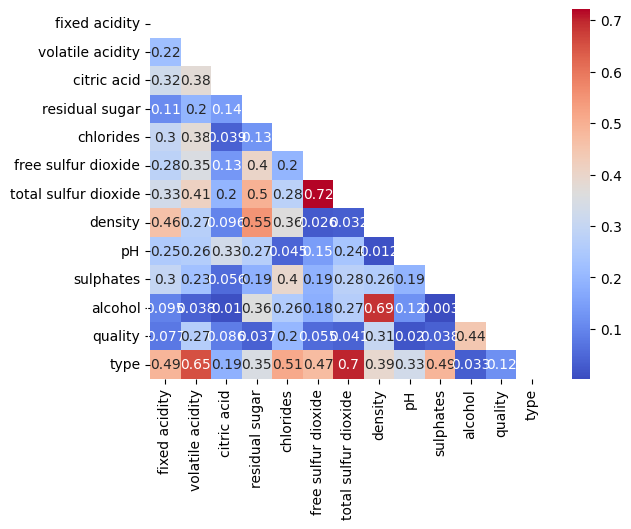

dropped: ['volatile acidity', 'free sulfur dioxide', 'total sulfur dioxide', 'density']


{'fixed acidity': np.float64(0.004108585519433353),
 'volatile acidity': np.float64(0.09203032589873057),
 'citric acid': np.float64(0.060848955477118355),
 'residual sugar': np.float64(0.08477796176937),
 'chlorides': np.float64(0.04006821890512115),
 'free sulfur dioxide': np.float64(0.595637968465383),
 'total sulfur dioxide': np.float64(0.024934164131318232),
 'density': np.float64(0.08477796176937),
 'pH': np.float64(0.0028568454711758143),
 'sulphates': np.float64(0.030076989519645308),
 'alcohol': np.float64(0.1627415313394367),
 'type': np.float64(0.01671814819485847)}

In [111]:
process_gain_ratio(total)

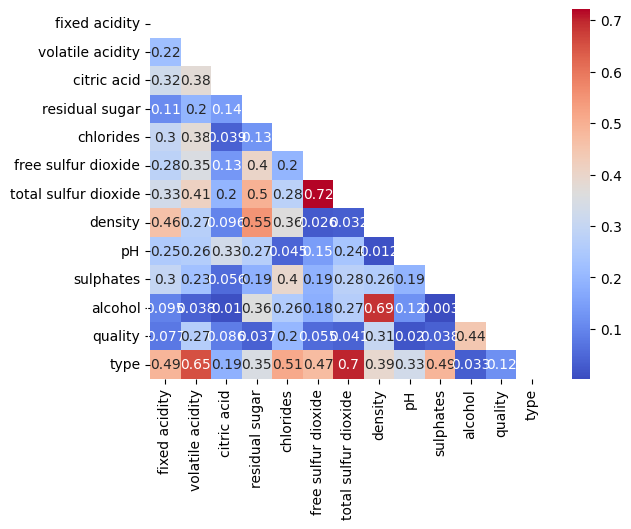

dropped: ['volatile acidity', 'free sulfur dioxide', 'total sulfur dioxide', 'density']


{'fixed acidity': np.float64(0.06332295701084391),
 'volatile acidity': np.float64(0.10628085339459695),
 'citric acid': np.float64(0.0747026673152998),
 'residual sugar': np.float64(0.06961522308314455),
 'chlorides': np.float64(0.078705336263377),
 'free sulfur dioxide': np.float64(0.10193671637272342),
 'total sulfur dioxide': np.float64(0.08905421137149196),
 'density': np.float64(0.07177846850100572),
 'pH': np.float64(0.08921262911049531),
 'sulphates': np.float64(0.09221358541255095),
 'alcohol': np.float64(0.1620853216713243),
 'type': np.float64(0.0010920304931461907)}

In [113]:
process_decision_tree(total)